[Open in Colab](https://colab.research.google.com/github/{username}/{repository}/blob/{branch}/{notebook_path})

# Data preperation

Import Libraries

In [1]:
# Data Manipulation
import numpy as np
import pandas as pd
import yfinance as yf

# Technical Indicators
import talib as ta

# Plotting graphs
import matplotlib.pyplot as plt

# Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score

Import Data: ETH-USD (1H timeframe) Period: 01/09/22 - 31/12/23

In [2]:
eth = yf.Ticker('ETH-USD')
interval = '1h'
start = '2022-9-1'
end = '2023-12-31'
df = eth.history(interval=interval,start=start,end=end)

df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2022-09-01 00:00:00+00:00,1553.756348,1563.172729,1540.025269,1551.280396,0,0.0,0.0
2022-09-01 01:00:00+00:00,1551.009644,1561.505615,1551.009644,1560.036377,0,0.0,0.0
2022-09-01 02:00:00+00:00,1559.819824,1571.228882,1555.293701,1555.791504,0,0.0,0.0
2022-09-01 03:00:00+00:00,1556.347534,1560.092896,1543.619263,1549.951904,0,0.0,0.0
2022-09-01 04:00:00+00:00,1550.056152,1554.786621,1546.588257,1553.971802,0,0.0,0.0


Check null

In [3]:
df.isnull().sum()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11639 entries, 2022-09-01 00:00:00+00:00 to 2023-12-30 23:00:00+00:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          11639 non-null  float64
 1   High          11639 non-null  float64
 2   Low           11639 non-null  float64
 3   Close         11639 non-null  float64
 4   Volume        11639 non-null  int64  
 5   Dividends     11639 non-null  float64
 6   Stock Splits  11639 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 727.4 KB


Delete Unnecessary columns (Volume, Dividendes, Stock Splits)

In [4]:
df.drop(columns=['Volume', 'Dividends', 'Stock Splits'], inplace=True)
df

,Open,High,Low,Close
Datetime,,,,
2022-09-01 00:00:00+00:00,1553.756348,1563.172729,1540.025269,1551.280396
2022-09-01 01:00:00+00:00,1551.009644,1561.505615,1551.009644,1560.036377
2022-09-01 02:00:00+00:00,1559.819824,1571.228882,1555.293701,1555.791504
2022-09-01 03:00:00+00:00,1556.347534,1560.092896,1543.619263,1549.951904
2022-09-01 04:00:00+00:00,1550.056152,1554.786621,1546.588257,1553.971802
...,...,...,...,...
2023-12-30 19:00:00+00:00,2302.610352,2304.096680,2298.136230,2298.970459
2023-12-30 20:00:00+00:00,2299.666504,2305.066650,2296.663086,2299.753906
2023-12-30 21:00:00+00:00,2298.176270,2303.271973,2298.176270,2301.439941


# 1. ETH Return (without ML)

คำนวณผลตอบแทนมาตรฐานของเหรียญ Ethereum (ETH)

In [5]:
X = df.iloc[:,:]
y = np.where(df['Close'].shift(-1) > df['Close'],1,-1)

df['ETH_returns'] = np.log(df['Close']/df['Close'].shift(1))
df = df.dropna()

split = int(0.7*len(df))
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

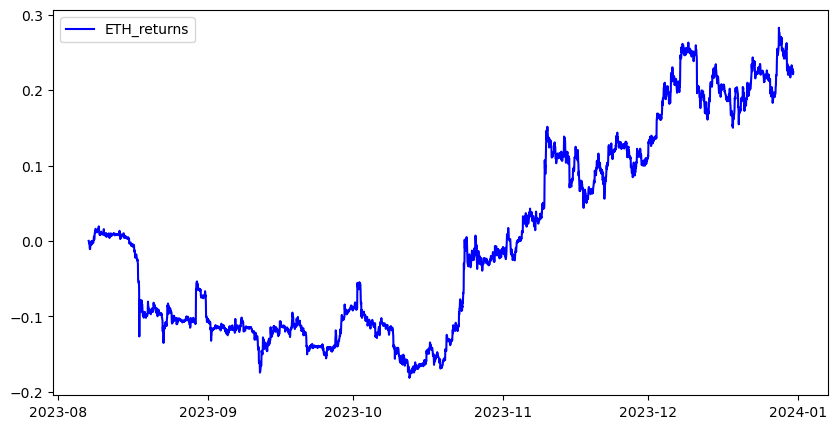

In [6]:
Cumulative_ETH_returns = np.cumsum(df[split:]['ETH_returns'])

plt.figure(figsize=(10,5))
plt.plot(Cumulative_ETH_returns, color='b', label = 'ETH_returns')
plt.legend()
plt.show()

# 2. Strategy: Logistic regression_Original features

In [7]:
X = df.iloc[:,:4]
y = np.where(df['Close'].shift(-1) > df['Close'],1,-1)

split = int(0.7*len(df))
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

model = LogisticRegression()
model = model.fit (X_train,y_train)

In [8]:
pd.DataFrame(zip(X.columns, np.transpose(model.coef_)))

,0,1
0,Open,[0.009051081424558806]
1,High,[0.0027958527228559822]
2,Low,[-0.0040054232553304]
3,Close,[-0.007853285789254889]


Model Evaluation

In [9]:
predicted = model.predict(X_test)
print(predicted)

[-1  1  1 ... -1  1 -1]


In [10]:
print(metrics.confusion_matrix(y_test, predicted))

[[1022  703]
 [ 929  838]]


In [11]:
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

          -1       0.52      0.59      0.56      1725
           1       0.54      0.47      0.51      1767

    accuracy                           0.53      3492
   macro avg       0.53      0.53      0.53      3492
weighted avg       0.53      0.53      0.53      3492



เปรียบเทียบผลตอบแทนมาตรฐานของ ETH (ETH returns) กับ Model Logistic regression ที่ไม่มี features เพิ่มเติม (Original Features returns)

จะเห็นได้ว่าผลตอบแทนของ Original Features returns สูงกว่า ETH returns เล็กน้อย

C:\Users\pangp\AppData\Local\Temp\ipykernel_15124\1995074579.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Original_Signal'] = model.predict(X)
C:\Users\pangp\AppData\Local\Temp\ipykernel_15124\1995074579.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Original_returns'] = df['ETH_returns'] * df['Original_Signal'].shift(1)


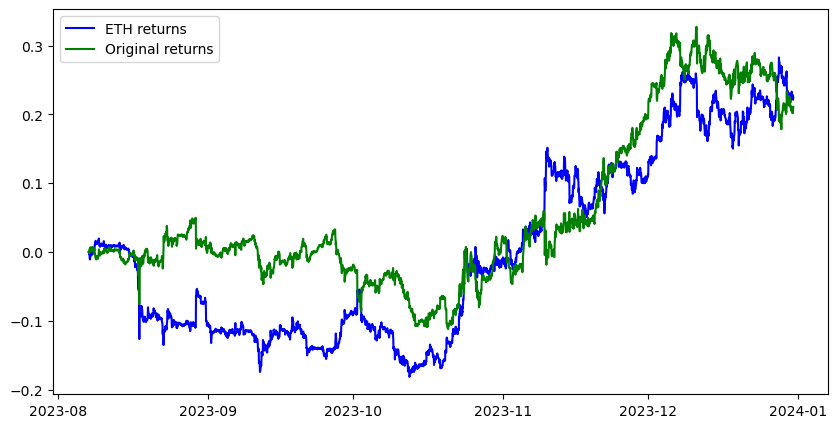

In [12]:
df['Original_Signal'] = model.predict(X)
df['Original_returns'] = df['ETH_returns'] * df['Original_Signal'].shift(1)

Cumulative_Strategy_returns = np.cumsum(df[split:]['Original_returns'])
plt.figure(figsize=(10,5))
plt.plot(Cumulative_ETH_returns, color='b', label = 'ETH returns')
plt.plot(Cumulative_Strategy_returns, color='g', label = 'Original returns')
plt.legend()
plt.show()

# 3. Strategy: Logistic regression_Adding features

เพิ่ม indicator features: ค่าเฉลี่ย(50), RSI(14), macd line, macd signal line

In [13]:
#Simple moving average 50 periods
df['S_50'] = df['Close'].rolling(window=50).mean()

#RSI 14 periods
df['RSI'] = ta.RSI(np.array(df['Close']), timeperiod =14)

#MACD
macd, signal, _ = ta.MACD(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
df['MACD'] = macd
df['Signal'] = signal

df = df.dropna()

C:\Users\pangp\AppData\Local\Temp\ipykernel_15124\601501258.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['S_50'] = df['Close'].rolling(window=50).mean()
C:\Users\pangp\AppData\Local\Temp\ipykernel_15124\601501258.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['RSI'] = ta.RSI(np.array(df['Close']), timeperiod =14)
C:\Users\pangp\AppData\Local\Temp\ipykernel_15124\601501258.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [14]:
X2 = df.iloc[:,7:]
y = np.where(df['Close'].shift(-1) > df['Close'],1,-1)

split = int(0.7*len(df))
X2_train, X2_test, y_train, y_test = X2[:split], X2[split:], y[:split], y[split:]

model2 = LogisticRegression()
model2 = model.fit (X2_train,y_train)

In [15]:
pd.DataFrame(zip(X2.columns, np.transpose(model.coef_)))

,0,1
0,S_50,[0.0001798373653223581]
1,RSI,[-0.0057485466985649466]
2,MACD,[-0.014127932943770643]
3,Signal,[0.016157140314455323]


In [16]:
predicted = model2.predict(X2_test)
print(predicted)

[1 1 1 ... 1 1 1]


In [17]:
print(metrics.confusion_matrix(y_test, predicted))

[[ 590 1127]
 [ 492 1268]]


In [18]:
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

          -1       0.55      0.34      0.42      1717
           1       0.53      0.72      0.61      1760

    accuracy                           0.53      3477
   macro avg       0.54      0.53      0.52      3477
weighted avg       0.54      0.53      0.52      3477



เปรียบเทียบผลตอบแทนมาตรฐานของ ETH (ETH returns) กับ Model Logistic regression ที่ไม่มี features เพิ่มเติม (Original Features returns) และ Model Logistic regression แบบมี features เพิ่มเติมได้แก่ MA, RSI และ MACD (Adding Features returns)

จะเห็นได้ว่าผลตอบแทนของ ETH returns และ No Features returns มีความใกล้เคียงกัน ส่วนค่า Adding Features returns มีผลตอบแทนต่ำที่สุด

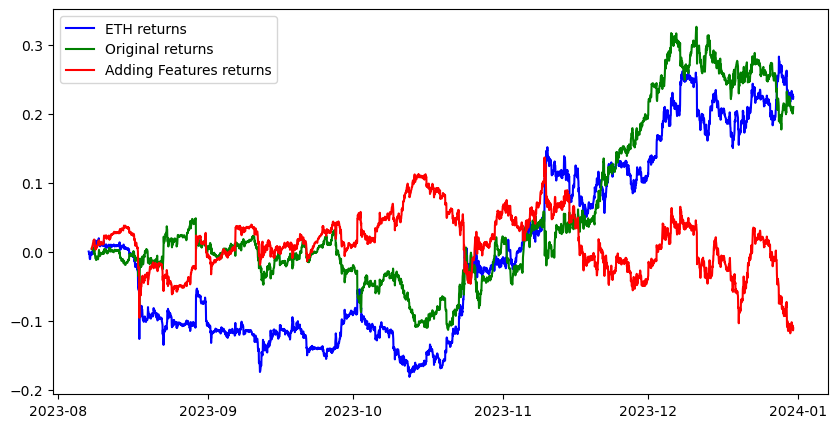

In [23]:
df['Adding_Signal'] = model2.predict(X2)
df['Adding_returns'] = df['ETH_returns'] * df['Adding_Signal'].shift(1)
Cumulative_Adding_returns = np.cumsum(df[split:]['Adding_returns'])

df['Original_returns'] = df['ETH_returns'] * df['Original_Signal'].shift(1)
Cumulative_Original_returns = np.cumsum(df[split:]['Original_returns'])

plt.figure(figsize=(10,5))
plt.plot(Cumulative_ETH_returns, color='b', label = 'ETH returns')
plt.plot(Cumulative_Original_returns, color='g', label = 'Original returns')
plt.plot(Cumulative_Adding_returns, color='r', label = 'Adding Features returns')
plt.legend()
plt.show()